# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Этап 1. Получение данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Прочитаем файл real_estate_data.csv и сохраним его в переменной data.

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal='.')

In [3]:
pd.set_option('display.max_columns', 50)

Получение первых 5 строк таблицы.

In [4]:
print(data.head(5))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт

Общая информация о данных таблицы.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Всего у нас 23699 строк, но в столбцах `ceiling_height`, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition` значений меньше, значит присутствуют пропуски.

У большинства переменных тип `float`, хотя многим, например балконам, это не свойственно.

У столбца 'is_apartment' тип `object`, хотя должен быть `bool`.

Посмотрим статистики:

In [7]:
pd.set_option('precision', 2)
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.00,2.37e+04,23699.00,23699.00,14504.00,23613.00,21796.00,23699.00,21421.00,12180.00,18157.00,18180.00,18181.00,8079.00,18181.00,9110.00,20518.00
mean,9.86,6.54e+06,60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,28793.67,14191.28,0.61,490.80,0.77,517.98,180.89
std,5.68,1.09e+07,35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,12630.88,8608.39,0.80,342.32,0.94,277.72,219.73
min,0.00,1.22e+04,12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3.40e+06,40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,18585.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4.65e+06,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13098.50,0.00,455.00,1.00,502.00,95.00
75%,14.00,6.80e+06,69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,37273.00,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,7.63e+08,900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Видим аномальные значения: квартира площадью 900 метров, при среднем 60; потолки высотой 100 метров; кухня площадью 1 метр; расстояние от квартиры до аэропорта 0 метров и т.д.

Визуализируем их:

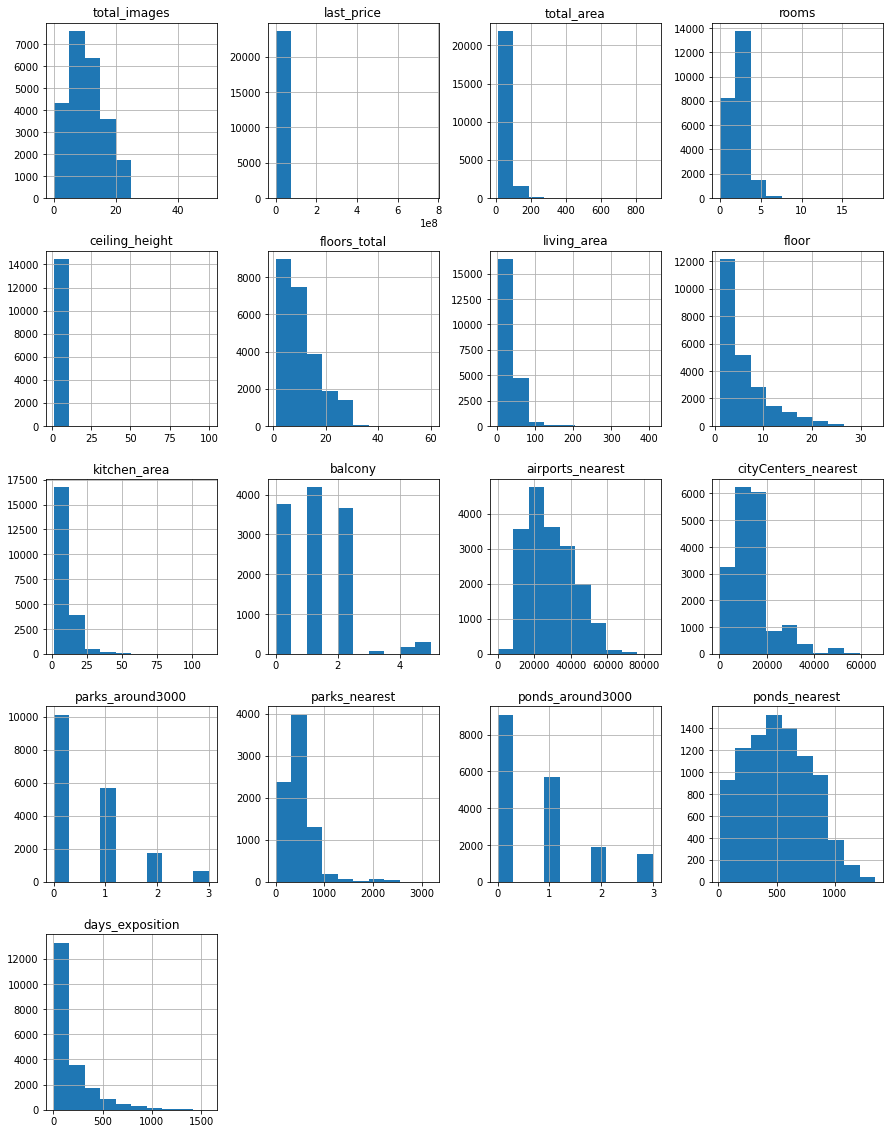

In [8]:
data.hist(figsize=(15, 20))
None

Наблюдаем гистограммы, на которых присутствует 1-2 столбца, что также подтверждает наличие множества аномальных значений в данных. Например для 'last_price' все "видимые" наблюдения утрамбовались в столбец 0 - 100 000 000, однако график говорит, что в данных присутствуют объекты стоимостью под 800 000 000.

### Этап 2. Предобработка данных

Проверим данные на наличие пропусков вызовом набора методов для суммирования пропущенных значений.

In [10]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Обдумаем пропуски:
- `ceiling_height` - высота потолков. Пропусков много. Можем предположить, что в домах одинаковой высоты одинаковая высота потолков. Заполним медианной высотой по зданиям одинаковой этажности;
- `floors_total` - количество этажей в доме. Пропусков незначительное количество, угадать высоту дома уже сложнее, плюс мы собираемся использовать этот параметр. Спокойно удаляем;
- `living_area` - жилая площадь. Пропусков много. Однако у нас нет пропусков в общей площади и количестве комнат. Так как жилая площадь учитывает как раз комнаты, можем предположить что в квартирах с одинаковым количеством комнат примерно одинаковый процент жилой и нежилой площади;
- `is_apartment` - объект является аппартаментами. 90% значений пропущено, не думаю, что этот столбец стоит использовать при анализе;
- `kitchen_area` - площадь кухни. Пропусков много. Поступим так же, как с жилой площадью;
- `balcony` - количество балконов. Предположим, что все пропущенные значения это нули;
- `locality_name` - название населённого пункта. Пропусков незначительное количество, угадать слишком сложно, спокойно удаляем.


In [11]:
#удаляем то, что решили удалить
data.dropna(subset=['floors_total'], inplace=True) 
data.dropna(subset=['locality_name'], inplace=True)
data = data.reset_index(drop=True)
data['balcony'] = data['balcony'].fillna(0)

print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area              1865
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64


Предполагаем ошибку при заполнении высоты потолков и делим указаенное число на 10, если при этом получается приемлемая высота потолка.

In [12]:
for i in range(len(data['ceiling_height'])): 
    if 14 < data.loc[i, 'ceiling_height'] < 100:
        data.loc[i, 'ceiling_height'] /= 10
        
print(data.isna().sum())        

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area              1865
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64


Заполним пропуски высоты потолков медианными значениями.

In [13]:
#заполняем высоту потолка
for current_floor in data['floors_total'].unique(): 
    data.loc[(data['floors_total'] == current_floor) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[data['floors_total'] == current_floor, 'ceiling_height'].median()
    
print(data.isna().sum())    

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              1
floors_total                0
living_area              1865
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64


/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [14]:
#заполняем жилую площадь
data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna(), 'total_area'] - data.loc[data['living_area'].isna(), 'kitchen_area']

print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              1
floors_total                0
living_area              1427
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64


In [15]:
#заполняем площадь кухни
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data.loc[data['kitchen_area'].isna(), 'total_area'] - data.loc[data['kitchen_area'].isna(), 'living_area']

print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              1
floors_total                0
living_area              1427
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             1427
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64


Проверим результат.

In [16]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              1
floors_total                0
living_area              1427
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             1427
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64


В `kitchen_area` остались пропуски из-за нулевого количества комнат в квартирах-студиях. Заполним эти пропуски нулями, так как в подобных квартирах не всегда можно отделить кухню от остальной квартиры.

Один пропуск остался в `ceiling_height` из-за дому уникальной высоты, удалим его.

Поменяем тип данных на целочисленный для количества балконов, этажей и т.д., как планировалось ранее.

In [17]:
data['kitchen_area'] = data['kitchen_area'].fillna(0)
data['living_area'] = data['living_area'].fillna(0)
data.dropna(subset=['ceiling_height'], inplace=True)
data = data.reset_index(drop=True)

data['floors_total'] = data['floors_total'].astype(int)
data['is_apartment'] = data['is_apartment'].astype(bool) 
data['balcony'] = data['balcony'].astype(int)

Проверим наличие неявных дубликатов, очистим от них таблицу.

In [18]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'СНТ')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество', 'СНТ')

Устраним аномальные значения.

In [19]:
data = data.query('300000 < last_price < 30000000')
data = data.query('total_area < 200')
data = data.query('rooms < 10')
data = data.query('2.40 <= ceiling_height <= 4')
data = data.query('living_area <= 120')
data = data.query('kitchen_area <= 40')
data = data.query('airports_nearest > 0 or airports_nearest.isna()')
data = data.query('10 <= parks_nearest <= 2500 or parks_nearest.isna()')
data = data.query('ponds_nearest >= 50 or ponds_nearest.isna()')
data = data.query('cityCenters_nearest <= 60000 or cityCenters_nearest.isna()')
data = data.query('airports_nearest <= 80000 or airports_nearest.isna()')

Проверим, что не удалили слишком много данных, и что оставшиеся данные выглядят адекватно.

In [21]:
print(len(data))

for column in data.columns:
    print(data[column].describe())
    print()
    print(data[column].value_counts().sort_index().head(10))
    print(data[column].value_counts().sort_index().tail(10))
    print()
    print('---------------------------------------------------------------------------------------------------')
    print()

22765
count    22765.00
mean         9.83
std          5.64
min          0.00
25%          6.00
50%          9.00
75%         14.00
max         50.00
Name: total_images, dtype: float64

0    1020
1     823
2     603
3     731
4     931
5    1252
6    1428
7    1475
8    1538
9    1685
Name: total_images, dtype: int64
28    4
29    3
30    2
31    2
32    4
35    2
37    1
39    1
42    1
50    3
Name: total_images, dtype: int64

---------------------------------------------------------------------------------------------------

count    2.28e+04
mean     5.56e+06
std      3.72e+06
min      4.30e+05
25%      3.40e+06
50%      4.55e+06
75%      6.50e+06
max      3.00e+07
Name: last_price, dtype: float64

430000.0    2
440000.0    1
450000.0    4
470000.0    3
480000.0    1
490000.0    2
500000.0    4
520000.0    1
530000.0    1
550000.0    5
Name: last_price, dtype: int64
2.90e+07    5
2.92e+07    1
2.94e+07    1
2.94e+07    1
2.95e+07    3
2.98e+07    1
2.98e+07    1
2.99e+07    2
3.00e

В результате предобработки были заполнены пропуски, отфильтрованы аномальные значения, из-за чего выборка сократилась на 4%, с 23699 наблюдений до 22765 наблюдений.

### Этап 3. Исследование данных

Добавим необходимые далее столбцы - с датами, ценой за метр квадратный, расстоянием до центра.

In [22]:
data['price_per_square_meter'] = data['last_price'] / data['total_area'] #добавили стоимость квадратного метра
data = data.query('18000 <= price_per_square_meter <= 600000') #на всякий случай отфильтровали по цене квадратного метра

#добавляем столбцы с датами
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#функция для определения типа этажа
def floor_type(floor, floors_total):
    if floor == floors_total:
        return 'последний'
    elif floor == 1:
        return 'первый'
    else:
        return 'другой'

data['floor_type'] = data.apply(lambda x: floor_type(x['floor'], x['floors_total']), axis=1)

#стобец с расстоянием до центра в км
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].round()

print('Оценка потерь: до выполнения этого блока у нас было 22 765 наблюдений, после выполнения стало:', len(data))

Оценка потерь: до выполнения этого блока у нас было 22 765 наблюдений, после выполнения стало: 22642


Визуализируем каждый из параметров квартиры отдельно.

_______________________________________________________________________________________________________________________________
**Общая площадь**

_______________________________________________________________________________________________________________________________

<AxesSubplot:>

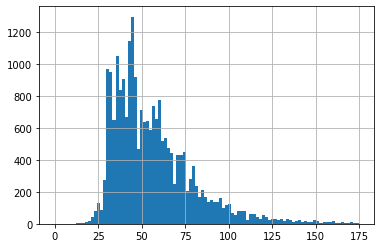

In [26]:
data['total_area'].hist(bins=100, range=(0, 175))

<AxesSubplot:>

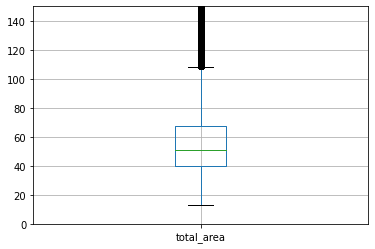

In [27]:
plt.ylim(0, 150)
data.boxplot(column='total_area')

Подавляющее большинство квартир имеют площадь менее 70 метров. Близость среднего и медианы, а так же отсутствие на `boxplot` отдельных точек говорит о приемлимом качестве очистки данных от выбросов.

Наблюдаем два пика, около 40 и около 60 метров. Можно предположить, что студии и однушки имеют площадь чуть меньше 50 метров, в то время как двухкомнатные квартиры - чуть больше 50, при этом трёшки вполне могут очнь близки по размерам к двушкам, из-за чего на 50 наблюдаем провал.

_______________________________________________________________________________________________________________________________
**Жилая площадь**

_______________________________________________________________________________________________________________________________

count    22642.00
mean        30.84
std         17.64
min          0.00
25%         18.00
50%         29.10
75%         41.00
max        120.00
Name: living_area, dtype: float64


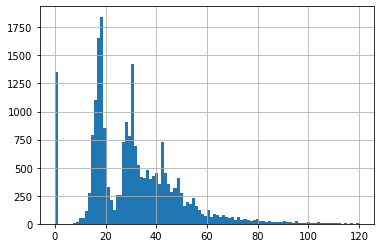

In [28]:
data['living_area'].hist(bins=100)
print(data['living_area'].describe())

<AxesSubplot:>

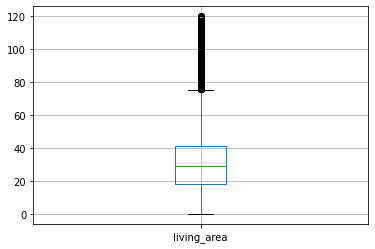

In [29]:
data.boxplot(column='living_area')

Близость среднего и медианы, а так же отсутствие на `boxplot` отдельных точек говорит о приемлимом качестве очистки данных от выбросов.

Так же наблюдаем два пика, аналогичной природы.

_______________________________________________________________________________________________________________________________
**Площадь кухни**

_______________________________________________________________________________________________________________________________

count    22642.00
mean         9.68
std          5.28
min          0.00
25%          6.80
50%          9.00
75%         11.50
max         40.00
Name: kitchen_area, dtype: float64


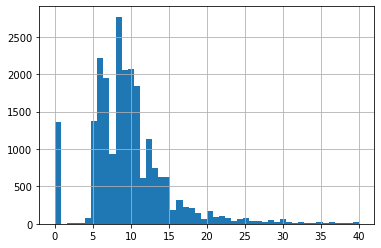

In [30]:
data['kitchen_area'].hist(bins=50)
print(data['kitchen_area'].describe())

<AxesSubplot:>

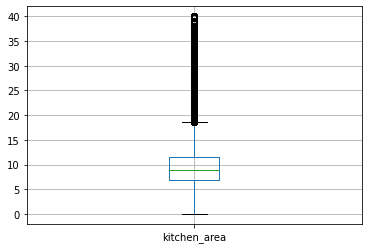

In [31]:
data.boxplot(column='kitchen_area')

Близость среднего и медианы, а так же отсутствие на `boxplot` отдельных точек говорит о приемлимом качестве очистки данных от выбросов.

Наблюдаем явные пики, можем предположить ступенчатое увеличение площади кухны в зависимости от количество комнат.

_______________________________________________________________________________________________________________________________
**Цена объекта**

_______________________________________________________________________________________________________________________________

count    2.26e+04
mean     5.58e+06
std      3.71e+06
min      5.50e+05
25%      3.40e+06
50%      4.59e+06
75%      6.50e+06
max      3.00e+07
Name: last_price, dtype: float64


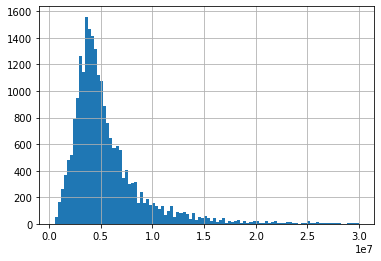

In [32]:
pd.set_option('precision', 2)
data['last_price'].hist(bins=100)
print(data['last_price'].describe())

<AxesSubplot:>

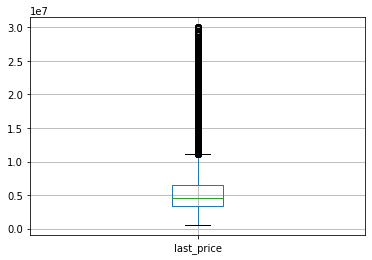

In [33]:
data.boxplot(column='last_price')

Для покупки квартиры придётся припасти несколько миллионов.

_______________________________________________________________________________________________________________________________
**Количество комнат**

_______________________________________________________________________________________________________________________________

count    22642.00
mean         2.01
std          0.97
min          0.00
25%          1.00
50%          2.00
75%          3.00
max          8.00
Name: rooms, dtype: float64


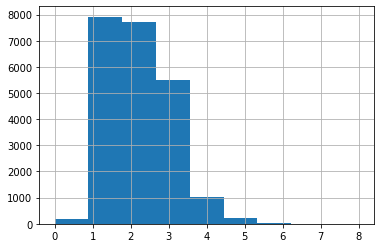

In [34]:
data['rooms'].hist(bins=9)
print(data['rooms'].describe())

<AxesSubplot:>

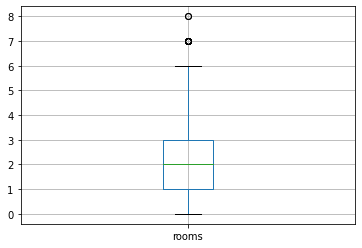

In [35]:
data.boxplot(column='rooms')

Пять и более комнат в квартирах встречаются крайне редко.

_______________________________________________________________________________________________________________________________
**Высота потолков**

_______________________________________________________________________________________________________________________________

count    22642.00
mean         2.70
std          0.21
min          2.40
25%          2.55
50%          2.65
75%          2.75
max          4.00
Name: ceiling_height, dtype: float64


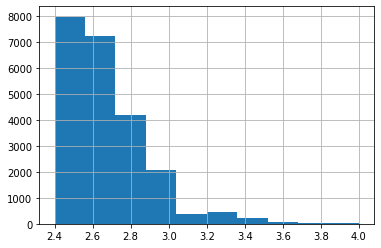

In [36]:
data['ceiling_height'].hist()
print(data['ceiling_height'].describe())

<AxesSubplot:>

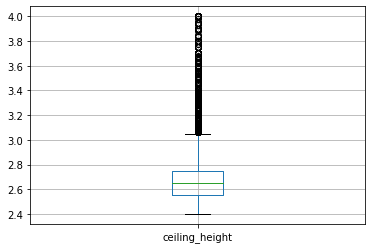

In [37]:
data.boxplot(column='ceiling_height')

Даже в Питере потолки выше 3 метров встречаются не часто.

_______________________________________________________________________________________________________________________________
**Этаж квартиры**

_______________________________________________________________________________________________________________________________

count    22642.00
mean         5.92
std          4.90
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         33.00
Name: floor, dtype: float64


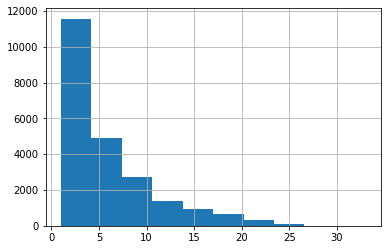

In [38]:
data['floor'].hist()
print(data['floor'].describe())

<AxesSubplot:>

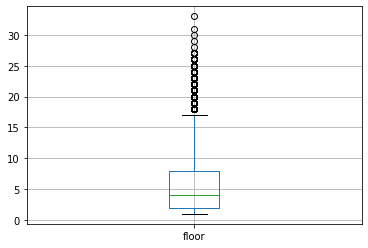

In [39]:
data.boxplot(column='floor')

Судя во всему в Питере и его окрестностях 30-ти этажные здания пока что редкость.

_______________________________________________________________________________________________________________________________
**Тип этажа квартиры**

_______________________________________________________________________________________________________________________________

count      22642
unique         3
top       другой
freq       16704
Name: floor_type, dtype: object


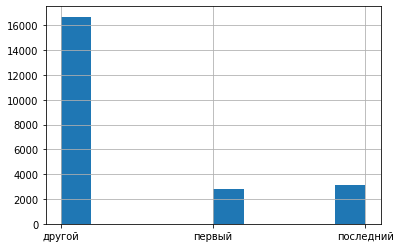

In [40]:
data['floor_type'].hist()
print(data['floor_type'].describe())

Около 10% первых и 10% последних, выглядит правдоподобно.

_______________________________________________________________________________________________________________________________
**Общее количество этажей в доме**

_______________________________________________________________________________________________________________________________

count    22642.00
mean        10.80
std          6.62
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64


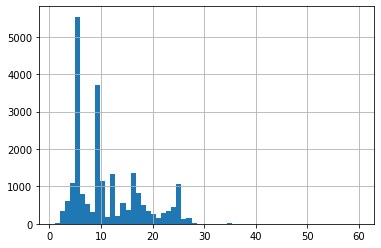

In [41]:
data['floors_total'].hist(bins=60)
print(data['floors_total'].describe())

<AxesSubplot:>

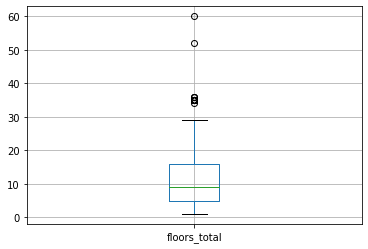

In [42]:
data.boxplot(column='floors_total')

Предыдущие выводы подтверждаются - забраться выше 30 этажа будет непросто.

_______________________________________________________________________________________________________________________________
**Расстояние до центра города в метрах**

_______________________________________________________________________________________________________________________________

count    17295.00
mean     14444.60
std       8499.86
min        208.00
25%       9761.50
50%      13251.00
75%      16394.00
max      59626.00
Name: cityCenters_nearest, dtype: float64


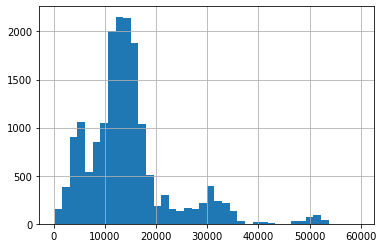

In [43]:
data['cityCenters_nearest'].hist(bins=40)
print(data['cityCenters_nearest'].describe())

<AxesSubplot:>

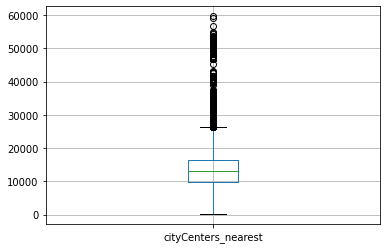

In [44]:
data.boxplot(column='cityCenters_nearest')

Судя по карте, границы города примерно в 15 км от центра, а после 30-35 км значительно снижается плотность наслённых пунктов. После 60 км их становится совсем мало. Плюс примерно в 40 километрах от центра города Ладыжское озеро. Это сопадает с полученными результатами - большая часть объявлений в пределах 15 км, потом сильная просадка после 35 км, и пустота на 60 км.

_______________________________________________________________________________________________________________________________
**Расстояние до ближайшего аэропорта**

_______________________________________________________________________________________________________________________________

count    17275.00
mean     28885.31
std      12740.06
min       6450.00
25%      18420.00
50%      26971.00
75%      37434.00
max      78527.00
Name: airports_nearest, dtype: float64


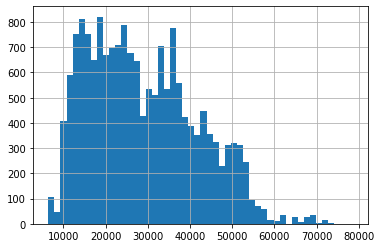

In [45]:
data['airports_nearest'].hist(bins=50)
print(data['airports_nearest'].describe())

<AxesSubplot:>

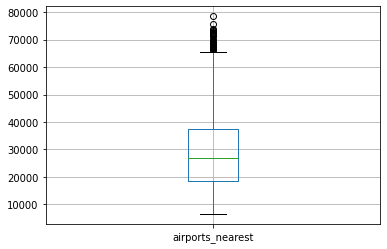

In [46]:
data.boxplot(column='airports_nearest')

Близость среднего и медианы, а так же отсутствие на boxplot отдельных точек говорит о приемлимом качестве очистки данных от выбросов.

_______________________________________________________________________________________________________________________________
**Расстояние до ближайшего парка**

_______________________________________________________________________________________________________________________________

count    7499.00
mean      488.12
std       324.12
min        10.00
25%       289.00
50%       456.00
75%       612.00
max      2489.00
Name: parks_nearest, dtype: float64


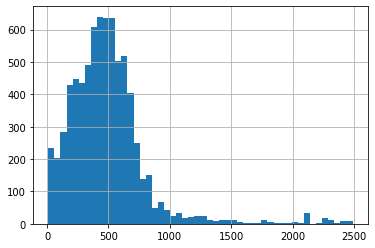

In [47]:
data['parks_nearest'].hist(bins=50)
print(data['parks_nearest'].describe())

<AxesSubplot:>

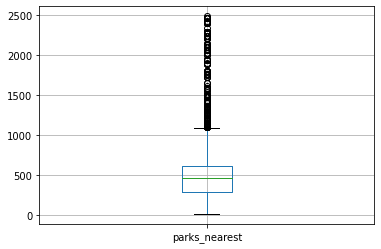

In [48]:
data.boxplot(column='parks_nearest')

Судя по всему, будет сложно найти место, чтобы в радиусе 1 км не было парка.

_______________________________________________________________________________________________________________________________
**День публикации объявления**

_______________________________________________________________________________________________________________________________

count    22642.00
mean         2.57
std          1.79
min          0.00
25%          1.00
50%          3.00
75%          4.00
max          6.00
Name: weekday, dtype: float64


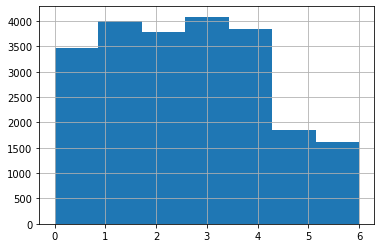

In [49]:
data['weekday'].hist(bins=7)
print(data['weekday'].describe())

Похоже люди предпочитают заниматься объявлениями о продаже квартир по будням. Вероятно это их работа.

_______________________________________________________________________________________________________________________________
**Месяц публикации объявления**

_______________________________________________________________________________________________________________________________

count    22642.00
mean         6.40
std          3.49
min          1.00
25%          3.00
50%          6.00
75%         10.00
max         12.00
Name: month, dtype: float64


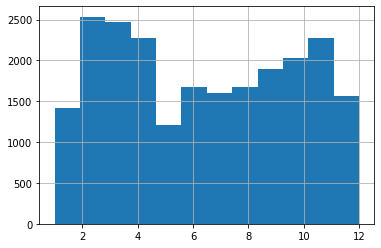

In [50]:
data['month'].hist(bins=12)
print(data['month'].describe())

Зимой и летом объявлений меньше, чем весной и осенью. Особенно мало в январе и мае. Вероятно это связано с отпусками и праздниками.

_______________________________________________________________________________________________________________________________
**Как быстро продавались квартиры**

_______________________________________________________________________________________________________________________________

count    19685.00
mean       177.42
std        215.33
min          1.00
25%         44.00
50%         94.00
75%        226.00
max       1580.00
Name: days_exposition, dtype: float64
0.1     17.0
0.9    449.0
Name: days_exposition, dtype: float64


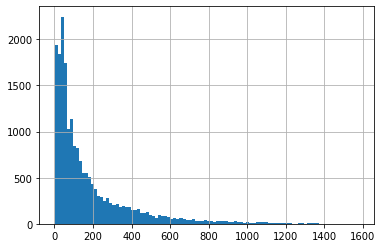

In [51]:
data['days_exposition'].hist(bins=100)
print(data['days_exposition'].describe())
print(data['days_exposition'].quantile([.1, .9]))

<AxesSubplot:>

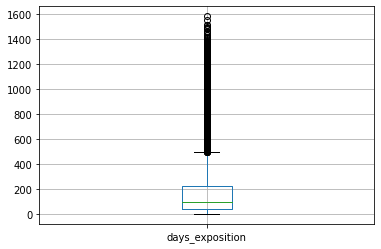

In [52]:
data.boxplot(column='days_exposition')

Ранее этот столбец был отфильтрован по отметке в три года. Согласно полученным данным большинству продавцов удастся заключить сделку в течении 3 месяцев. Это бьётся с доступной в интернете информацией - разные источники указывают средний срок продажи квартиры в Санкт-Петербурге от 62 до 122 дней.

Вопрос о быстрых и долгих продажах не так однозначен. Допустим мы возмём по 10% с каждой стороны. Тогда быстрыми будут продажи в течении 2.5 недель, долгими - затянувшиеся более чем на 14 месяцев.

Оценив корреляции определим, какие факторы больше всего влияют на общую (полную) стоимость квартиры.

In [53]:
corr_data = data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', 'weekday', 'month', 'year']]
corr_data.corr()

,last_price,total_area,living_area,kitchen_area,rooms,weekday,month,year
last_price,1.00e+00,0.78,5.73e-01,0.47,4.91e-01,-2.05e-02,8.59e-03,-2.62e-02
total_area,7.83e-01,1.00,7.95e-01,0.43,7.94e-01,-1.71e-02,1.15e-02,-7.30e-02
living_area,5.73e-01,0.79,1.00e+00,0.43,7.56e-01,-2.65e-02,8.25e-03,-6.72e-02
kitchen_area,4.65e-01,0.43,4.27e-01,1.00,1.39e-01,-2.87e-02,1.21e-02,-5.87e-02
rooms,4.91e-01,0.79,7.56e-01,0.14,1.00e+00,-5.85e-03,-1.62e-03,-4.22e-02
weekday,-2.05e-02,-0.02,-2.65e-02,-0.03,-5.85e-03,1.00e+00,1.11e-02,-2.56e-03
month,8.59e-03,0.01,8.25e-03,0.01,-1.62e-03,1.11e-02,1.00e+00,-2.75e-01
year,-2.62e-02,-0.07,-6.72e-02,-0.06,-4.22e-02,-2.56e-03,-2.75e-01,1.00e+00


Смотрим первый столбец. Общая площадь, жилая площадь, площадь кухни и количество комнат имеют положительную корреляцию с ценой квартиры (0,8, 0,6, 0,5 и 0,5 соответственно). В целом все эти показатели отражают одну характеристику - размер жилья, поэтому было бы странным, если бы они слабо или по разному коррелировали с ценой, так как размер покупаемой квартиры должен быть ключевым фактором.

День недели и месяц года не имеют влияния на цену квартиры, что логично. Год, в свою очередь, по идее должен влиять, как минимум из-за инфляции. Проверим даты.

In [54]:
print(data['first_day_exposition'].min())
print(data['first_day_exposition'].max())

2014-11-27 00:00:00
2019-05-03 00:00:00


Данные представлены за 4 полных года, 2015-2018 включительно, плюс начало 2019-го. Согласно источникам в это время цены на жильё в Санкт-Петербурге были стабильны, держались около 100-110 тысяч за квадратный метр, начав расти только в 2019-ом. Это объясняет отсутствие взаимосвязи цены и года.

**Визуализируем взаимосвязи.**

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

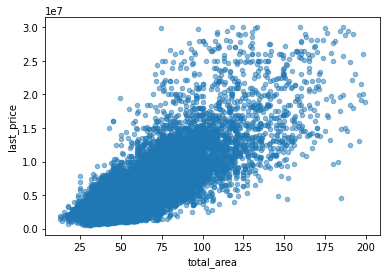

In [55]:
corr_data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.5) 

Видим, как точки скопились на диагонали от левого нижнего к правому верхенму углу, что говорит о положительной взаимосвязи.

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

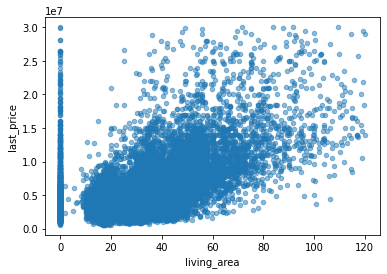

In [56]:
corr_data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.5) 

Видим, как точки скопились на диагонали от левого нижнего к правому верхенму углу, что говорит о положительной взаимосвязи.

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

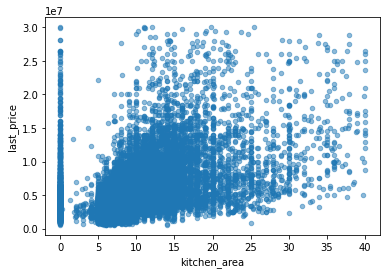

In [57]:
corr_data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.5) 

Уже не так хорошо, но видим, как точки скопились на диагонали от левого нижнего к правому верхенму углу, что говорит о положительной взаимосвязи.

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

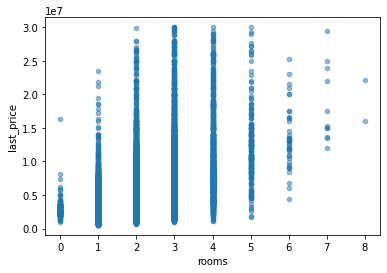

In [58]:
corr_data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.5) 

Уже не так хорошо, но видим, как точки скопились на диагонали от левого нижнего к правому верхенму углу, что говорит о положительной взаимосвязи.

<AxesSubplot:xlabel='floor_type'>

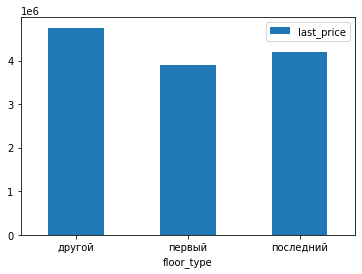

In [59]:
data.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot.bar(rot=0)


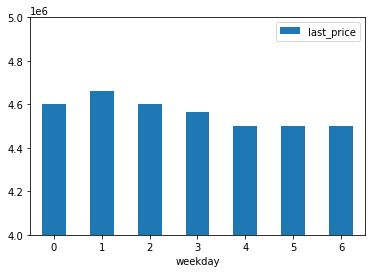

In [60]:
data.pivot_table(index='weekday', values='last_price', aggfunc='median').plot.bar(rot=0)
plt.ylim(4000000, 5000000)
None

Видим, что колебания медианной цены в зависимости от дня недели минимальны.

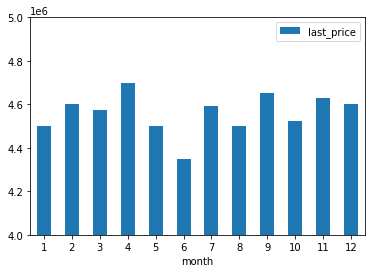

In [61]:
data.pivot_table(index='month', values='last_price', aggfunc='median').plot.bar(rot=0)
plt.ylim(4000000, 5000000)
None

Видим, что колебания медианной цены в зависимости от месяца года минимальны, за исключением 6-го месяца.

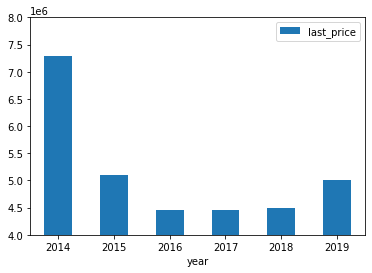

In [62]:
data.pivot_table(index='year', values='last_price', aggfunc='median').plot.bar(rot=0)
plt.ylim(4000000, 8000000)
None

Видим, что колебания медианной цены в 2016-2018 годах минимальны. Ранее было озвучено:
>Согласно источникам в это время цены на жильё в Санкт-Петербурге были стабильны, держались около 100-110 тысяч за квадратный метр, начав расти только в 2019-ом.

Это мы и наблюдаем на графике. Пик 2014-2015 года предположительно можно объйснить следующим образом: на очень дорогие квартиры не очень высокий спрос, поэтому при завышенной или справедливой, но всё-равно высокой цене, квартира будет продаваться долго, из-за этого медианная цена 2014 года такая высокая - это квартиры которые не могут найти своего покупатяеля более 5 лет, а это вряд ли из-за того, что они очень дешёвые.

_______________________________________________________________________________________________________________________________
**Определим среднюю цену одного квадратного метра в населённых пунктах с наибольшим числом объявлений.**

_______________________________________________________________________________________________________________________________

In [63]:
price_pivot = data.pivot_table(index='locality_name', values='price_per_square_meter', aggfunc=['median', 'count'])
price_pivot.columns=('mean', 'count')
top_10 = price_pivot.sort_values(by='count', ascending=False).head(10)
print(top_10)

                        mean  count
locality_name                      
Санкт-Петербург    104026.85  14913
поселок Мурино      86042.64    551
поселок Шушары      76876.17    438
Всеволожск          65789.47    393
Пушкин              99865.71    358
Колпино             74723.75    334
поселок Парголово   91780.22    326
Гатчина             67924.53    305
деревня Кудрово     91860.47    299
Выборг              58233.01    234


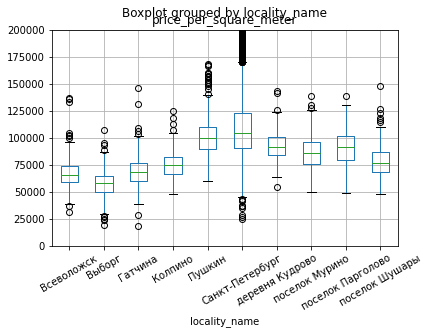

In [64]:
data_top_10 = data.query('locality_name in @top_10.index')
data_top_10.boxplot(column='price_per_square_meter', by='locality_name')
plt.ylim(0, 200000)
plt.xticks(rotation=30)
None

**Определим населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

In [66]:
price_pivot = price_pivot.query('count >= 20')
print(price_pivot.sort_values(by='mean').head(1))
print(price_pivot.sort_values(by='mean').tail(1))

                   mean  count
locality_name                 
Сланцы         20731.71     57
                      mean  count
locality_name                    
Санкт-Петербург  104026.85  14913


_______________________________________________________________________________________________________________________________
**Вычислите среднюю цену каждого километра.**

_______________________________________________________________________________________________________________________________

                             mean     median      count
                       last_price last_price last_price
cityCenters_nearest_km                                 
0                       9,788,000  8,395,000         10
1                      10,529,919  9,200,000        124
2                      10,281,115  9,000,000        244
3                       9,383,260  8,000,000        316
4                      10,021,148  8,725,246        619
5                      10,385,905  8,765,000        815
6                       9,239,430  7,946,910        518
7                       9,144,699  6,990,000        361
8                       8,629,427  7,200,000        570
9                       6,652,353  5,200,000        573
10                      6,277,459  5,000,000        699
11                      5,967,435  4,999,000       1153
12                      5,770,280  4,950,000       1580
13                      6,002,000  5,200,000       1436
14                      5,521,386  4,850,000    

<AxesSubplot:xlabel='cityCenters_nearest_km'>

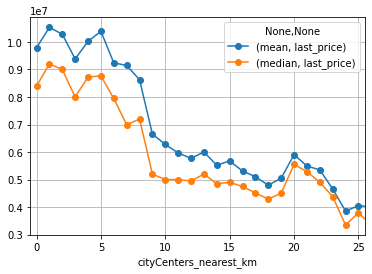

In [67]:
pd.options.display.float_format ='{:,.0f}'.format
spb_data = data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc=['mean', 'median', 'count'])
print(spb_data)
spb_data.plot(y=['mean', 'median'], kind='line', style='-o', xlim=(-0.5, 25.5), grid=True)

Видим предсказуемую зависимость - цена жилья снижается по мере удаления от центра города. Можно обозначить радиус в 0-5км как "центр" с наиболее дорогими вариантами, 6-8км что-то среднее, 9-13км "окраина" с самыми дешёвыми квартирами внутри города.

### Этап 4. Результаты исследования

_______________________________________________________________________________________________________________________________
Цена на жильё в Питере около 200 000 за квадратный метр, чем дальше от центра города и самого города, тем дешевле. Жильё на первых и последних этажах продаётся с дисконтом из-за своих особенностей. Квартиры больше 120 метров - редкость, здания больше 30 этажей - тоже. Продать квартиру скорее всего удастся в течении трёх месяцев. Далеко от парка поселится не получится, в 10 минутах ходьбы какой-нибудь точно найдётся. Квартира скорее всего будет в 5-ти этажке со стандартными потолками 2.4-2.8 метра, несмотря на стереотип о высоких потолках в Питере. В праздничные сезоны найти квартиру будет немного сложнее, однако на цену это не повлияет.
_______________________________________________________________________________________________________________________________